# Moving averages

In [1]:
from os.path import exists
import numpy as np
import pandas as pd
import pandas_datareader.data as reader
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
stocks = ["MFED.PA", "PE500.PA", "EN.PA", "CNP.PA", "TTE.PA", "^GSPC"]
    
def get_data(fetch=False, stocks=stocks):
    PATH = 'data/moving_averages.csv'
    end = dt.datetime.now()
    start = dt.date(end.year - 5, end.month, end.day)

    if fetch or not exists(PATH):
        df = reader.get_data_yahoo(stocks, start, end)["Adj Close"].dropna()
        df.to_csv(PATH)
    else:
        df = pd.read_csv(PATH, parse_dates=[0], index_col=0)
    return df
    

## Get stocks data

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

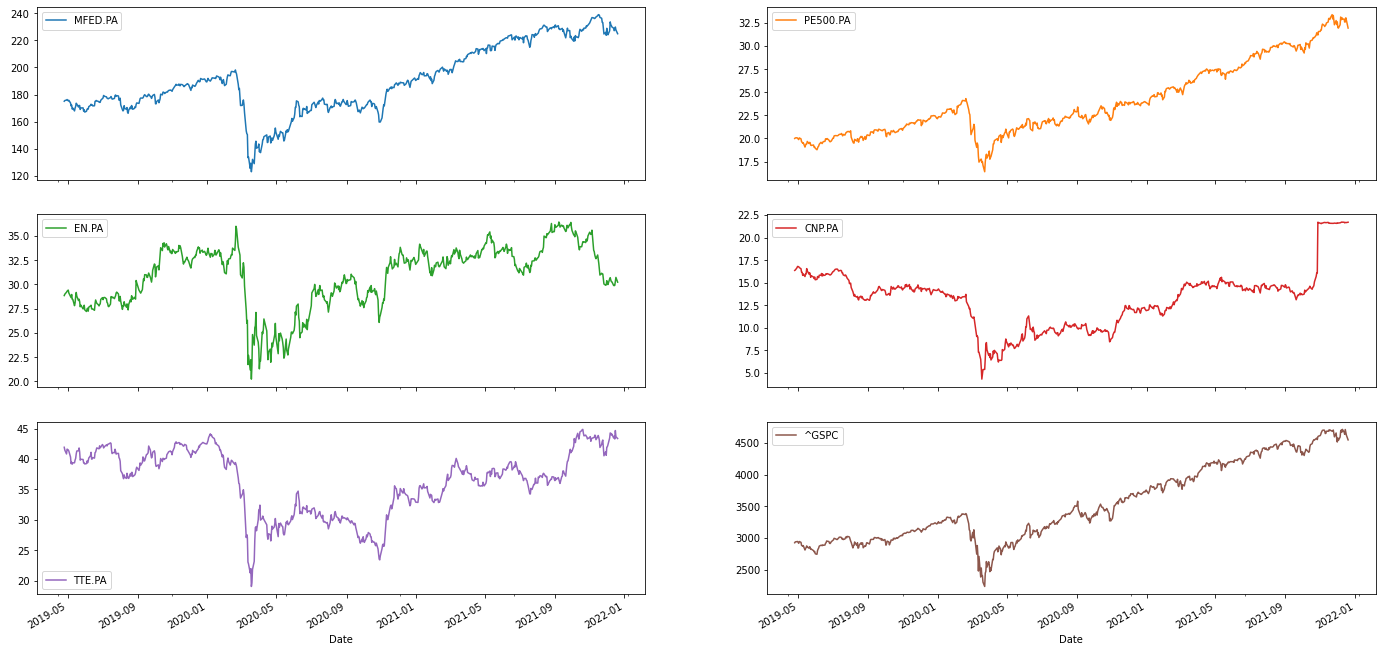

In [3]:
df = get_data()

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))

## Example of a strategy base on 2 simple moving averages

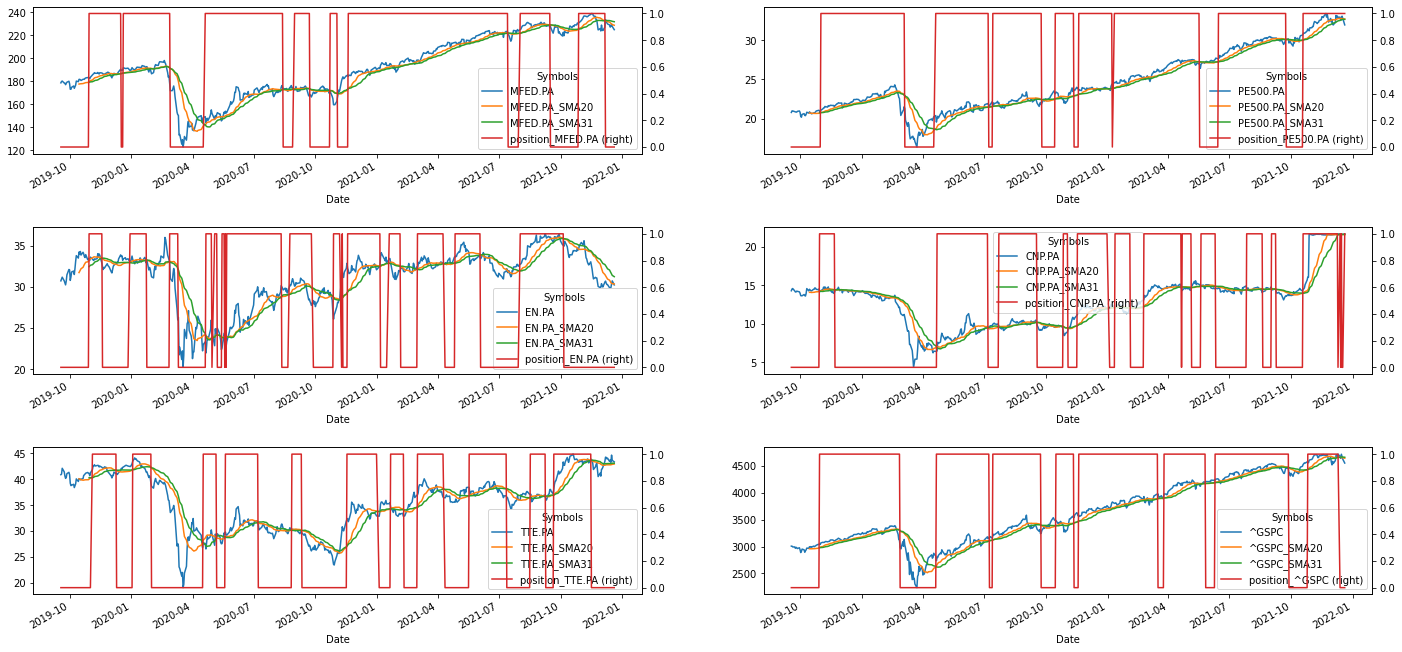

In [15]:
SMA1 = 20
SMA2 = 31

fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[f'{s}_SMA{SMA1}'] = df[s].rolling(SMA1).mean()
    df[f'{s}_SMA{SMA2}'] = df[s].rolling(SMA2).mean()
    df[f'position_{s}'] = np.where(df[f'{s}_SMA{SMA1}'] > df[f'{s}_SMA{SMA2}'], 1, 0)

    df[[s, f'{s}_SMA{SMA1}', f'{s}_SMA{SMA2}', f'position_{s}']].plot(figsize=(24, 12), ax=axes[i // 2, i % 2], secondary_y=f'position_{s}')

## Compute strategy returns and compare to stock returns

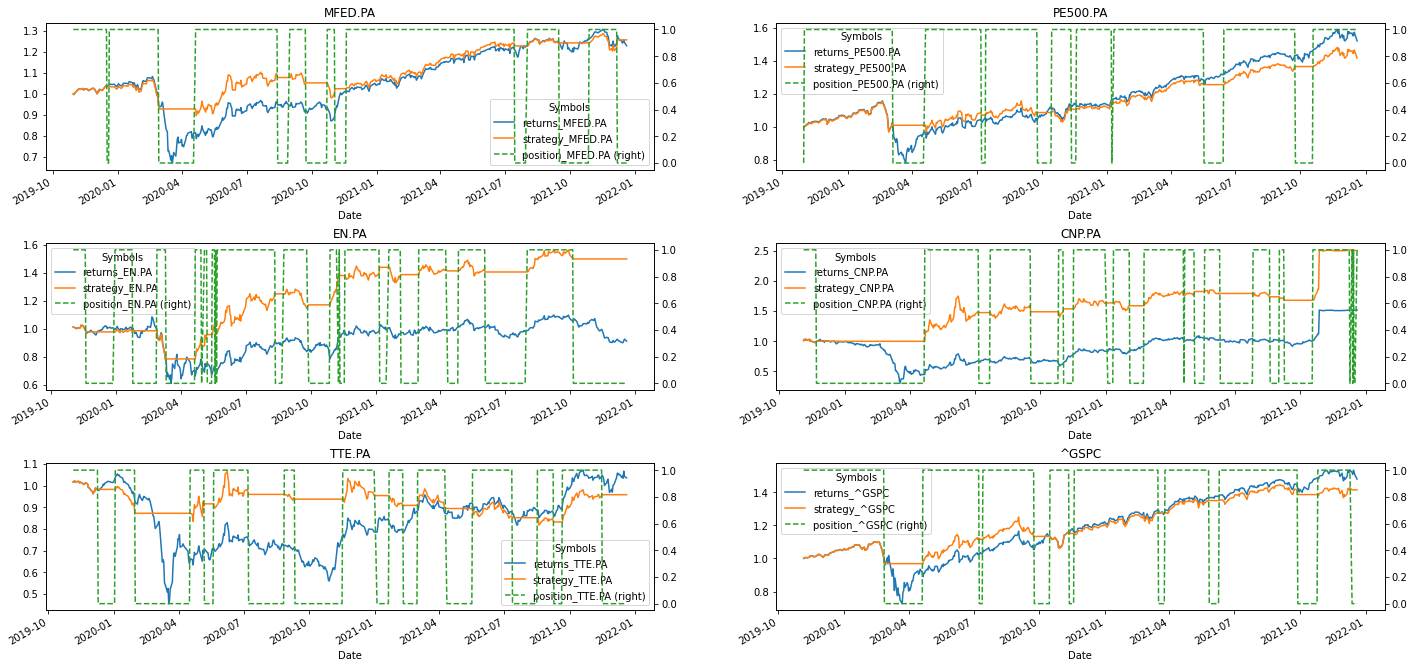

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    df[f'returns_{s}'] = np.log(df[s] / df[s].shift(1))
    df[f'strategy_{s}'] = df[f'position_{s}'].shift(1) * df[f'returns_{s}']
    df.dropna(inplace=True)

    ax = df[[f'returns_{s}', f'strategy_{s}']].cumsum().apply(np.exp).plot(figsize=(24, 12), ax=axes[i // 2, i % 2])
    df[[f'position_{s}']].plot(figsize=(24, 12), ax=ax, secondary_y=f'position_{s}', style='--')
    plt.title(s)

## Compute best simple moving average pair

In [6]:
from itertools import product

sma1 = range(2, 100, 1)
sma2 = range(4, 252, 1)

results = pd.DataFrame()
symbols = stocks[:-1]

for SMA1, SMA2 in product(sma1, sma2):
    if SMA1 >= SMA2:
        continue
        
    data = pd.DataFrame(df[symbols])
    data.dropna(inplace=True)
    
    for s in symbols:
        data[f'{s}_returns'] = np.log(data[s] / data[s].shift(1))
        data[f'{s}_SMA1'] = data[s].rolling(SMA1).mean()
        data[f'{s}_SMA2'] = data[s].rolling(SMA2).mean()
    
        data[f'{s}_position'] = np.where(data[f'{s}_SMA1'] > data[f'{s}_SMA2'], 1, 0)
        data[f'{s}_strategy'] = data[f'{s}_position'].shift(1) * data[f'{s}_returns']
    
    data.dropna(inplace=True)
    
    total_strategy = np.exp(data[[f'{s}_strategy' for s in symbols]].sum().sum())
    total_returns = np.exp(data[[f'{s}_returns' for s in symbols]].sum().sum())

    results = results.append(pd.DataFrame({
        'SMA1': SMA1,
        'SMA2': SMA2,
        'market': total_returns,
        'strategy': total_strategy,
        'out': total_strategy - total_returns
    }, index=[0]), ignore_index=True)
    
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19648 entries, 0 to 19647
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      19648 non-null  int64  
 1   SMA2      19648 non-null  int64  
 2   market    19648 non-null  float64
 3   strategy  19648 non-null  float64
 4   out       19648 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 767.6 KB


In [7]:
results.sort_values('out', ascending=False).head(7)

,SMA1,SMA2,market,strategy,out
1234,7,8,3.202050,9.955456,6.753405
5,2,9,3.206694,6.713688,3.506993
4338,20,31,3.313216,6.702616,3.389400
252,3,8,3.202050,6.465810,3.263759
1236,7,10,3.101552,6.081465,2.979913
251,3,7,3.234312,6.137556,2.903244
992,6,10,3.101552,6.002933,2.901381


## Conclusion

- We did not find a SMA pair that consistently have higher returns than staying in the market
- In the method to find the best pair, all stocks were equally weighted
- SMA cannot be used for buy/sell signals by itself

- Try with 3 SMA to generate signal
- Try to optimize with weights